# 网格搜索

现在我们知道了如果评估一个模型的泛化能力，下面继续学习通过调参来提升模型的泛化性能。scikit-learn 中许多算法的参数设置，在尝试调参之前重要的是要理解参数的含义。找到一个模型的重要参数(提供最佳泛化性能的参数)的取值是一项棘手的任务，但对于几乎所有模型和数据集来说都是必要的。由于这项任务如此常见，所以scikit-learn 中有一些标准方法可以帮你完成。最常用的方法就是**网格搜索**(gridsearch)，它主要是指尝试我们关心的参数的所有可能组合。

考虑一个具有RBF(径向基函数)核的核SVM的例子，它在SVC类中实现。它有2个重要参数:核宽度 gamma 和正则化参数C。假设我们希望尝试C的取值为0.001、0.01、0.1、1、10 和100，gamma 也取这6个值。由于我想要尝试的C和gamma都有6个不同的取值，所以总共有 36 种参数组合。所有可能的组合组成了SVM的参数设置表(网格)，如下所示。

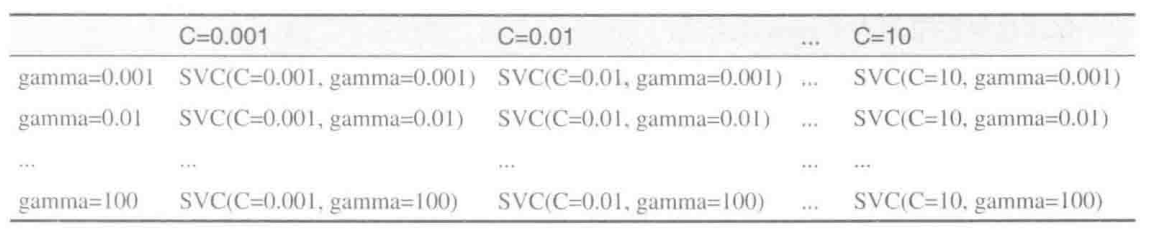

## 1. 简单网格搜索

我们可以实现一个简单的网格搜索，在2个参数上使用 for 循环，对每种参数组合分别训练并评估一个分类器:

In [1]:
# 简单的网格搜索实现
from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()
X_train, X_test, y_train, y_test =  train_test_split(iris.data, iris.target, random_state=0)
print("Size of train set: {}    Size of test set: {}".format(X_train.shape[0], X_test.shape[0]))

best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 1, 100]:
    for C in [0.001, 0.01, 0.1, 1, 1, 100]:
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        score = svm.score(X_test, y_test)
        
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}
        
print("Best score: {:.2f}".format(best_score))
print("Best parameters: {}".format(best_parameters))

Size of train set: 112    Size of test set: 38
Best score: 0.97
Best parameters: {'C': 100, 'gamma': 0.001}


## 2. 参数过拟合的风险与验证集

看到这个结果，我们可能忍不住要报告，我们找到了一个在数据集上精度达到 97% 的模型。然而，这种说法可能过于乐观了 (或者就是错的)，其原因如下:我们尝试了许多不同的参数，并选择了在测试集上精度最高的那个，但这个精度不一定能推广到新数据上。由于我们使用测试数据进行调参，所以不能再用它来评估模型的好坏。我们最开始需要将数据划分为训练集和测试集也是因为这个原因。我们需要一个独立的数据集来进行评估个在创建模型时没有用到的数据集。

为了解决这个问题，一种方法是再次划分数据，这样我们得到3 个数据集:用于构建模型的训练集，用于选择模型参数的验证集(开发集)，用于评估所选参数性能的测试集。

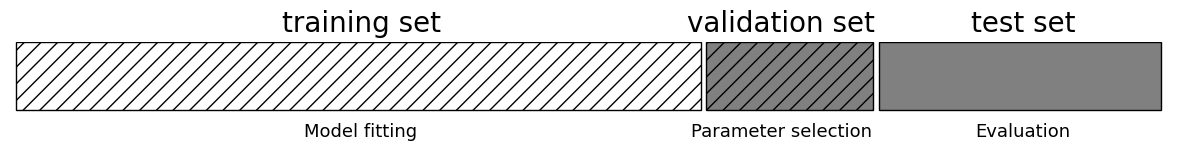

In [2]:
# 对数据进行3折划分，分为训练集、验证集和测试集
import mglearn 
mglearn.plots.plot_threefold_split()

利用验证集选定最佳参数之后，我们可以利用找到的参数设置重新构建一个模型，但是要同时在训练数据和验证数据上进行训练。这样我们可以利用尽可能多的数据来构建模型.其实现如下所示:

In [3]:
X_trainval, X_test, y_trainval, y_test = train_test_split(
    iris.data, iris.target, random_state=0)
# split train+validation set into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(
    X_trainval, y_trainval, random_state=1)
print("Size of training set: {}   size of validation set: {}   size of test set:"
      " {}\n".format(X_train.shape[0], X_valid.shape[0], X_test.shape[0]))

best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # for each combination of parameters, train an SVC
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        # evaluate the SVC on the validation set
        score = svm.score(X_valid, y_valid)
        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}

# rebuild a model on the combined training and validation set,
# and evaluate it on the test set
svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)
test_score = svm.score(X_test, y_test)
print("Best score on validation set: {:.2f}".format(best_score))
print("Best parameters: ", best_parameters)
print("Test set score with best parameters: {:.2f}".format(test_score))

Size of training set: 84   size of validation set: 28   size of test set: 38

Best score on validation set: 0.96
Best parameters:  {'C': 10, 'gamma': 0.001}
Test set score with best parameters: 0.92


验证集上的最高分数是 96%，这比之前略低，可能是因为我们使用了更少的数据来训练模型(现在 X_tratn 更小，因为我们对数据集做了两次划分)。但测试集上的分数 (这个分数实际反映了模型的泛化能力) 更低，为92%。因此，我们只能声称对92% 的新数据正确分类，而不是我们之前认为的97%!

训练集、验证集和测试集之间的区别对于在实践中应用机器学习方法至关重要。任何根据测试集精度所做的选择都会将测试集的信息“泄漏”(leak) 到模型中。因此，保留一个单独的测试集是很重要的，它仅用于最终评估。好的做法是利用训练集和验证集的组合完成所有的探索性分析与模型选择，并保留测试集用于最终评估一一即使对于探索性可视化也是如此。严格来说，在测试集上对不止一个模型进行评估并选择更好的那个，将会导致对模型精度过于乐观的估计。

## 3. 带交叉验证的网格搜索

In [4]:
from sklearn.model_selection import cross_val_score
import numpy as np

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        svm = SVC(gamma=gamma, C=C)
        scores = cross_val_score(svm, X_trainval, y_trainval, cv=5)
        score = np.mean(scores)
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}
svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)
test_score = svm.score(X_test, y_test)
print("Best score on validation set: {:.2f}".format(best_score))
print("Best parameters: ", best_parameters)
print("Test set score with best parameters: {:.2f}".format(test_score))

Best score on validation set: 0.97
Best parameters:  {'C': 10, 'gamma': 0.1}
Test set score with best parameters: 0.97


要想使用5折交叉验证对C和gamma 特定取值的SVM的精度进行评估，需要训练36x5=180个模型。你可以想象，使用交叉验证的主要缺点就是训练所有这些模型所需花费的时间。

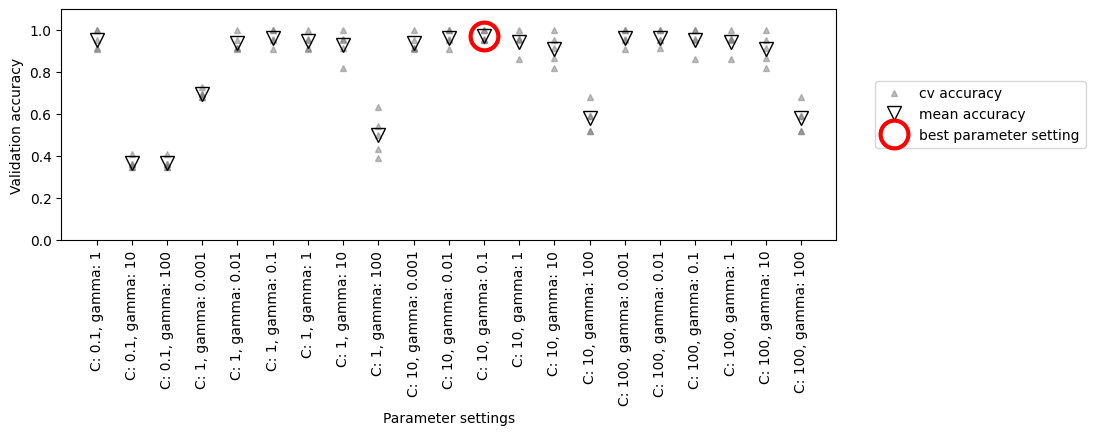

In [5]:
# 带交叉验证的网格搜索结果
mglearn.plots.plot_cross_val_selection()

对于每种参数设置(图中仅显示了一部分)，需要计算 5个精度值，交叉验证的每次划分都要计算一个精度值。然后，对每种参数设置计算平均验证精度。最后，选择平均验证精度最高的参数，用圆圈标记。

划分数据、运行网格搜索并评估最终参数，这整个过程如图所示。

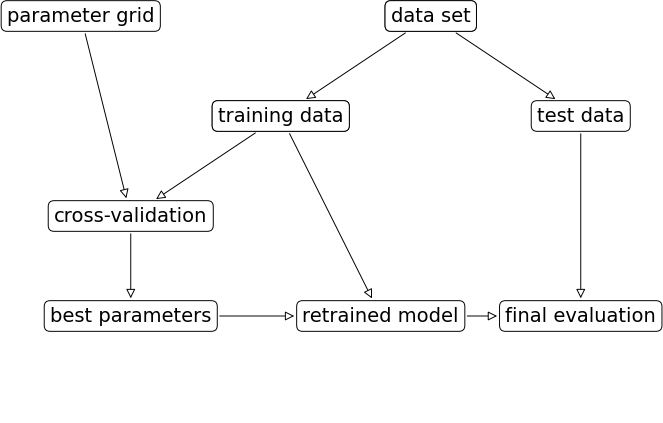

In [6]:
# 用GridSearchCV进行参数选择与模型评估的过程概述
mglearn.plots.plot_grid_search_overview()

由于带交叉验证的网格搜索是一种常用的调参方法，因此scikit-learn 提供了GridSearchCV类，它以估计器 (estimator)的形式实现了这种方法。要使用GridSearchCv类，你首先需要用一个字典指定要搜索的参数。然后GridsearchcV会执行所有必要的模型拟合。字典的键是我们要调节的参数名称(在构建模型时给出，在这个例子中是C和gamma)，字典的值是我们想要尝试的参数设置。如果C和 gamma 想要尝试的取值为 0.001、0.01、0.1、1、10和100，可以将其转化为下面这个字典:

In [7]:
param_grid = {'C' : [0.001, 0.01, 0.1, 1, 10, 100], 'gamma':[0.001, 0.01, 0.1, 1, 10, 100]}
print("Parameter grid:\n {}".format(param_grid))

Parameter grid:
 {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}


现在我们可以使用模型(SVC)、要搜索的参数网格(param_grid) 与要使用的交叉验证策略(比如5折分层交叉验证)将GridSearchcv类实例化:

In [8]:
from sklearn.model_selection import GridSearchCV  # GridSearch和CV，即网格搜索和交叉验证
from sklearn.svm import SVC

grid_search = GridSearchCV(SVC(), param_grid, cv=5)

Gridsearchcv将使用交叉验证来代替之前用过的划分训练集和验证集方法。但是，我们仍需要将数据划分为训练集和测试集，以避免参数过拟合:

In [9]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=0)

我们创建的 grid_search 对象的行为就像是一个分类器，我们可以对它调用标准的fitpredict和score方法。但我们在调用fit 时，它会对 param grid指定的每种参数组合都运行交叉验证:

In [10]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1, 10, 100]})

拟合GridSearchCV对象不仅会搜索最佳参数，还会利用得到最佳交叉验证性能的参数在整个训练数据集上自动拟合一个新模型。GridSearchCV类提供了一个非常方便的接口，可以用predict和 score方法来访问重新训练过的模型。为了评估找到的最住参数的泛化能力，我们可以在测试集上调用 score:

In [11]:
print("Test set score: {:.3f}".format(grid_search.score(X_test, y_test)))

Test set score: 0.974


利用交叉验证选择参数，我们实际上找到了一个在测试集上精度为 97.4% 的模型。重要的是，我们没有使用测试集来选择参数。我们找到的参数保存在 best_params_属性中，而交又验证最佳精度(对于这种参数设置，不同划分的平均精度) 保存在 best_score_中:

In [12]:
print("Best parameters: {}".format(grid_search.best_params_))
print("Best coress-validation score: {:.3f}".format(grid_search.best_score_))

Best parameters: {'C': 10, 'gamma': 0.1}
Best coress-validation score: 0.973


能够访问实际找到的模型，这有时是很有帮助的，比如查看系数或特征重要性。你可以用best_estimator_属性来访间最佳参数对应的模型，它是在整个训练集上训练得到的:

In [13]:
print("Best estimator:\n {}".format(grid_search.best_estimator_))

Best estimator:
 SVC(C=10, gamma=0.1)


行预测或评估模型
由于grid_search 本身具有 predict和score方法，所以不需要使用best_estimator_来进

### 1.分析交叉验证的结果

将交叉验证的结果叫视化通常有助于理解模型泛化能力对所搜索参数的依赖关系。由干运行网格搜索的计算成本相当高，所以通常最好从相对比较稀疏且较小的网格开始搜索。然后我们可以检查交叉验证网格搜索的结果，可能也会扩展搜索范围。网格搜索的结果可以在cv_results_属性中找到，它是一个字典，其中保存了搜索的所有内容。你可以在下面的输出中看到，它里面包含许多细节，最好将其转换成pandas数据框后再查看：

In [14]:
import pandas as pd
# 转换为DataFrame（数据框）
result = pd.DataFrame(grid_search.cv_results_)
display(result.head())

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001141,0.001402,0.003084,0.003438,0.001,0.001,"{'C': 0.001, 'gamma': 0.001}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22
1,0.003910,0.005488,0.000476,0.000594,0.001,0.01,"{'C': 0.001, 'gamma': 0.01}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22
2,0.001306,0.000613,0.000805,0.000403,0.001,0.1,"{'C': 0.001, 'gamma': 0.1}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22
3,0.001578,0.000476,0.001004,0.000631,0.001,1,"{'C': 0.001, 'gamma': 1}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22
4,0.001909,0.000204,0.001138,0.000198,0.001,10,"{'C': 0.001, 'gamma': 10}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22


results中每一行对应一种特定的参数设置。时于每种参数设置.交叉验证所有划分的结 果都被记录下来.所有划分的平均值和标准差也被记录下来。由于我们搜索的是一个二维参数网格(C和gamma),所以最适合用热图可视化(见图5-8)。我们首先提取平均验证分 数，然后改变分数数组的形状、使其坐标轴分别对应于C 和gamma：

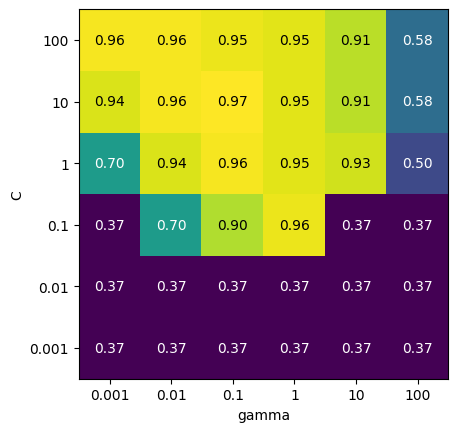

In [15]:
# 以C和gamma为自变量，交叉验证平均分数的热图

scores = np.array(result.mean_test_score).reshape(6, 6)
# 对交叉验证平均分数作图
mglearn.tools.heatmap(scores, xlabel='gamma', xticklabels=param_grid['gamma'], ylabel='C', yticklabels=param_grid['C'], cmap='viridis')

热图中的每个点对应于运行一次交叉险证以及一种特定的参数设置。颜色去示交叉验证的精度：浅色表示高精度，深色表示低精度。你可以看到，SVC对参数设置非常敏感。对于许多种参数设置，精度都在40%左右，这是非常糟糕的，对于其他参数设置，精度约为96%。我们可以从这张图中看出以下几点。首先，我们调节的参数对于获得良好的性能 非常重要。这两个参数（C 和gamma）都很重要，因为调节它们可以将精度从40% 提高到 96%。此外，在我们选择的参数范围中也可以看到输出发生显著的变化。同样重要的是要注意，参数的范围要足够大：每个参数的最佳取值不能位丁图像的边界上。


下面我们来看几张图， 其结果不那么理想，因为选择的搜索范围不合适。

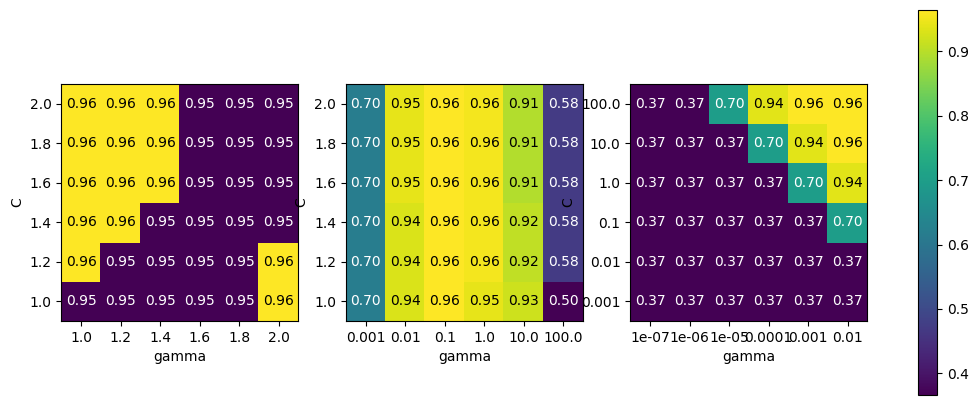

In [16]:
# 错误的搜索网格的热图可视化

import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 3, figsize=(13, 5))
# linspace用于在指定的间隔内生成等间隔的数列
param_grid_linear = {'C' : np.linspace(1, 2, 6),  'gamma' : np.linspace(1, 2, 6)}
# logspace可以生成一个等比数列，这个数列中的每个元素都是以指数形式递增的。
param_grid_one_log = {'C' : np.linspace(1, 2, 6), 'gamma' : np.logspace(-3, 2, 6)}
param_grid_range = {'C' : np.logspace(-3, 2, 6), 'gamma' : np.logspace(-7, -2, 6)}

for param_grid, ax in zip([param_grid_linear, param_grid_one_log, param_grid_range], axes):
    grid_search = GridSearchCV(SVC(), param_grid, cv=5)
    grid_search.fit(X_train, y_train)
    # 网格搜索的结果可以在cv_results_属性中找到，它是一个字典，其中保存了搜索的所有内容
    scores = grid_search.cv_results_['mean_test_score'].reshape(6, 6)
    # 对交叉验证平均分数作图
    scores_image = mglearn.tools.heatmap(scores, xlabel='gamma', xticklabels=param_grid['gamma'], ylabel='C', yticklabels=param_grid['C'], cmap='viridis', ax=ax)

plt.colorbar(scores_image, ax=axes.tolist())

第一张图数值变化。在这种情况下，这是由参数C和 gamma不正确的缩放以及不正确的范围造成的。但如果对于不同的参数设置都看不到精度 的变化，也可能是因为这个参数根本不重要。通常最好在开始时尝试非常极端的值，以观察改变参数是否会导致精度发生变化。

第二张图显示的是垂直条形模式。这表示只有gamma的设置对精度有影响。这可能意味 着gamma参数的搜索范围是我们所关心的，而C参数并不是 也可能意味着C参数并不重要。

第三张图中C和gamma对应的精度都有变化。但可以看到，在图像的整个左下角都没有发生什么有趣的事情。我们在后面的网格搜索中可以不考虑非常小的值。最佳参数设置出现在右上角。由于最佳参数位于图像的边界，所以我们可以认为，往这个边界之外可能还有更好的取值，我们可能希望改变搜索范围以包含这一区域内的更多参教。

基于交叉验证分数来调节参数网格是非常好的，也是探索不同参数的重要性的好方法。但是，你不应该在最终测试集上测试不同的参数范围 前而说过，只有确切知道了想要使用的模型，才能对测试集进行评估。

### 2. 在非网格的空间中搜索

在某些情况下，尝试所有参数的所有可能组合(正如GddSearchCV所做的那样)并不是一个好主意。例如，SVC有一个kernel参数，根据所选择的kernel (内核)，其他参数也是与之相关的。如果kernel='linear'， 那么模型是线性的，只会用到 C 参数。如果 kernel= 'rbf',则需要使用 C 和 gamma两个参数(但用不到类似degree的其他参数)。在这种情况下，搜 索 C，gamma和 kernel所有可能的组合没有意义；如果kernel='linear',那么gamma是用不到的，尝试gamma的不同取值将会浪费时间。为了处理这种“条件" (conditional)参数，GridSearchCV 的 param_grid 可以是字典组成的列表 (a list of dictionaries )。 列表中的每个字典可扩展为一个独立的网格。包含内核与参数的网格搜索可能如下所示。

In [17]:
param_grid = [ {'kernel' : ['rbf'], 'C' : [0.001, 0.01, 0,1, 1, 10, 100], 'gamma' : [0.001, 0.01, 0.1, 1, 10, 100]},
              {'kernel' : ['linear'], 'C' : [0.001, 0.01, 0.1, 1, 10, 100]}]
print("List of grids:\n {}".format(param_grid))

List of grids:
 [{'kernel': ['rbf'], 'C': [0.001, 0.01, 0, 1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}, {'kernel': ['linear'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}]


在第一个网格中,kernel参数始终等于'rbf'(注意kernel是一个长度为1的列表)，而 C 和 gemma 都是变化的。在第二个网格中, kernel参数始终等'linear', 只有C是变化的。下面我们来应用这个更加复杂的参数搜索：

In [18]:
grid_search = GridSearchCV(SVC(), param_grid, cv=5, return_train_score=True)
# grid_search.verbose = 2
grid_search.fit(X_train, y_train)
print("Best parametes: {}".format(grid_search.best_params_))
print("Best coress-validation score: {:.3f}".format(grid_search.best_score_))

Best parametes: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Best coress-validation score: 0.973


D:\python\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
30 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "D:\python\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\python\lib\site-packages\sklearn\svm\_base.py", line 180, in fit
    self._validate_params()
  File "D:\python\lib\site-packages\sklearn\base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "D:\python\lib\site-packages\sklearn\utils\_param_validation.py", line 97, in validate_parameter_constraints

再次查看cv_results_。正如所料.如果kernel等于 linear,, 那么只有C是变化的

In [19]:
results = pd.DataFrame(grid_search.cv_results_)
# 我们给出的是转置后的表格.这样更适5 页面眼示：
display(results.T)

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
mean_fit_time,0.001822,0.001257,0.00121,0.003083,0.002331,0.003095,0.001609,0.001403,0.000305,0.001224,...,0.000101,0.0,0.003726,0.0,0.0,0.000375,0.0004,0.000811,0.000199,0.000261
std_fit_time,0.000714,0.000456,0.00041,0.004692,0.003209,0.005136,0.003218,0.000801,0.000611,0.001791,...,0.000202,0.0,0.006062,0.0,0.0,0.000478,0.000489,0.000406,0.000398,0.000521
mean_score_time,0.000772,0.000393,0.000856,0.00032,0.0,0.0,0.0,0.000845,0.000095,0.000662,...,0.0,0.002409,0.0,0.0,0.00021,0.000302,0.001391,0.000199,0.000204,0.000102
std_score_time,0.000742,0.000481,0.000442,0.00064,0.0,0.0,0.0,0.000437,0.000189,0.000548,...,0.0,0.004818,0.0,0.0,0.00042,0.000402,0.002315,0.000399,0.000409,0.000204
param_C,0.001,0.001,0.001,0.001,0.001,0.001,0.01,0.01,0.01,0.01,...,100,100,100,100,0.001,0.01,0.1,1,10,100
param_gamma,0.001,0.01,0.1,1,10,100,0.001,0.01,0.1,1,...,0.1,1,10,100,NaN,NaN,NaN,NaN,NaN,NaN
param_kernel,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,...,rbf,rbf,rbf,rbf,linear,linear,linear,linear,linear,linear
params,"{'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 1, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 10, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 100, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 1, 'kernel': 'rbf'}",...,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 100, 'gamma': 1, 'kernel': 'rbf'}","{'C': 100, 'gamma': 10, 'kernel': 'rbf'}","{'C': 100, 'gamma': 100, 'kernel': 'rbf'}","{'C': 0.001, 'kernel': 'linear'}","{'C': 0.01, 'kernel': 'linear'}","{'C': 0.1, 'kernel': 'linear'}","{'C': 1, 'kernel': 'linear'}","{'C': 10, 'kernel': 'linear'}","{'C': 100, 'kernel': 'linear'}"
split0_test_score,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,...,1.0,0.956522,0.869565,0.521739,0.347826,0.869565,1.0,1.0,1.0,0.956522
split1_test_score,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,...,0.956522,0.956522,0.913043,0.521739,0.347826,0.869565,0.913043,0.956522,1.0,0.956522


### 3. 使用不同的交叉验证策略进行网格搜索

与cross_val_score类似，GridSearchCV对分类问题默认使用分层4 折交更骏证,对回归 问题默认使用 k 折交义验证。但是，你可以传入任何交又验证分离器作为GridSearchCV的 cv 参数,正如“对交叉验证的更多控制”部分所述。特别地，如果只想将数据单次划分为训练集和验证集,你可以使用ShuffleSplit或StratifiedShuffleSplit,并 设置n_iter=1， 这时于非常大的数据集或非常慢的模型可能会有帮助。 

#### (1) 嵌套交叉验证

前面的例子中,我们先介绍了将数据单次划分为训练集、验证集与测试集,然后介绍了先将数据划分为训练集和测试集，再在训练集上进行交叉验证。但前面在使用 GridSearchCV时,我们仍然将数据单次划分为训练集和测试集，这可能会导致结果不稳定，也止我们过于依赖数据的此次划分，我们可以停深入一点，不是只将原始数据一次划分为训练集和测试集，而是使用交叉验证进行多次期分，这就是所谓的**嵌套交叉验证** (nested cross-validation)。 在嵌套交义验证中，有一个外层循环，遍历将数据划分为训练集和测试集的所有划分。对于每种划分都运行一次网格搜索(对干外层循环的每种划分可能会得到不同的最佳参数)。然后，对于每种外层划分,利用最佳参数设置计算得到测试集分数。

这一过程的结果是由分数组成的列表，不是一个模型，也不是一种参数设置。这些分数告诉我们在网格找到的最佳参数下模型的泛化能力好坏。由于嵌套交叉验证不提供可用于新数据的模型，所以在寻找可用于未来数据的预测模型时很少用到它。但是，它对于评估给定模型住特定数据集上的效果很行用。

在scikit-learn中实现嵌套交叉验证很简单。我们调川cross_val_ score, 并用GridSearchCV 的一个实例作为模型：

In [24]:
scores = cross_val_score(GridSearchCV(SVC(), param_grid, cv=5), iris.data, iris.target, cv=5)
# print("Cross-validation scores: ", scores) 


# 使用适当的格式字符串将每个分数保留三位小数并格式化为字符串
formatted_scores = ["{:.3f}".format(score) for score in scores]

# 将格式化后的字符串连接起来
formatted_scores_str = ", ".join(formatted_scores)

# 打印结果
print("Cross-validation scores: [{}]".format(formatted_scores_str))

print("Mean cross-validation score: ", scores.mean())

D:\python\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
30 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "D:\python\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\python\lib\site-packages\sklearn\svm\_base.py", line 180, in fit
    self._validate_params()
  File "D:\python\lib\site-packages\sklearn\base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "D:\python\lib\site-packages\sklearn\utils\_param_validation.py", line 97, in validate_parameter_constraints

Cross-validation scores: [0.967, 1.000, 0.900, 0.967, 1.000]
Mean cross-validation score:  0.9666666666666668


D:\python\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
30 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "D:\python\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\python\lib\site-packages\sklearn\svm\_base.py", line 180, in fit
    self._validate_params()
  File "D:\python\lib\site-packages\sklearn\base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "D:\python\lib\site-packages\sklearn\utils\_param_validation.py", line 97, in validate_parameter_constraints

嵌套交义验证的结果可以总结为"SVC在iris 数据集上的交叉验证平均精度为98%",不多也不少。


这里我们在内层循环和外层循环中都使用了分层5折交叉验证。由干param_grid包含36种参敖组合，所以需要构建36 x 5 x 5 = 900个模型，导致嵌套交叉验证过程的代价很高。这里我们在内层循环和外层循环中使用相同的交叉验证分离器，但这不是必需的,你可以 在内层循环和外层循环中使用交叉验证策略的任意组合。理解上面单行代码的内容可能有点困难，将其展开为for循环可能会有所帮助，正如我们在下面这个简化的实现中所做的那样：

In [35]:
def nested_cv(X, y, inner_cv, outer_cv, Classifier, parameter_grid):
    outer_scores = []
    # 对不外层交叉验证的每次数据划分，split方法返回索引值 
    for training_samples, test_samples in outer_cv.split(X, y):
        # 利用内层交叉验证找到最佳参数
        best_parms = {}
        best_score = -np.inf
        # iterate over parameters
        for parameters in parameter_grid:
            # 住内层划分中累加分数
            cv_scores = []
            # 遍历内层交叉验证
            for inner_train, inner_test in inner_cv.split(
                    X[training_samples], y[training_samples]):
                # 对于给定的参荻和训练数据来构建分卖器
                clf = Classifier(**parameters)
                clf.fit(X[inner_train], y[inner_train])
                # 在内层测试集上进行评估
                score = clf.score(X[inner_test], y[inner_test])
                cv_scores.append(score)
            # 计算内层交叉验证的平均分数
            mean_score = np.mean(cv_scores)
            if mean_score > best_score:
                # 茹果比前面的模司都要好，则保存其参数
                best_score = mean_score
                best_params = parameters
        # 利用外层训练集和最佳参数来构建模型
        clf = Classifier(**best_params)
        clf.fit(X[training_samples], y[training_samples])
        # 评估模型
        outer_scores.append(clf.score(X[test_samples], y[test_samples]))
    return np.array(outer_scores)

In [37]:
from sklearn.model_selection import ParameterGrid, StratifiedKFold

scores = nested_cv(iris.data, iris.target, StratifiedKFold(5),
                   StratifiedKFold(5), SVC, ParameterGrid(param_grid))
# 使用适当的格式字符串将每个分数保留三位小数并格式化为字符串
formatted_scores = ["{:.3f}".format(score) for score in scores]

# 将格式化后的字符串连接起来
formatted_scores_str = ", ".join(formatted_scores)

# 打印结果
print("Cross-validation scores: [{}]".format(formatted_scores_str))


Cross-validation scores: [0.967, 1.000, 0.967, 0.967, 1.000]


#### (2) 交叉验证与网格搜索并行

虽然在许多参数上运行网格搜索和在大型数据集上运行网格搜索的计算量可能很大，但令人尴尬的是，这些计算都是并行的(parallel)。这也就是说，在一种交叉验证划分下使用特定参数设置来构建一个模型，与利用其他参数的模型是完全独立的。这使得网格搜索与交叉验证成为多个CPU内核或集群上并行化的理想选择。你可以将n_jobs参数段置为你想使用的CPU内核数量，从而在GridSearchCV和 cross_val_score 中使用多个内核。你可以设置n_jobs=-1来使用所行可用的内核。

scikit-learn不允许并行操作的嵌套。因此，如果你在模型(比如随机森 林)中使用了 n_jobs选项，那么就不能在GridSearchCV使用它来搜索这个型。如果你的数据集和模型部非常大，那么使用多个内核可能会占用大量内存，你应该在并行构建大 型模型时监视内存的使用情况。

还可以在集群内的多台机器上并行运行网格搜索和交叉验证，对于 Spark 用户，还可以使用最新升发的 spark-sklearn 包